#X-Ray Scattering Data

In [1]:
%matplotlib inline

import json as json
import numpy as np
import matplotlib.pylab as plt
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error as mse
from scipy.signal import gaussian

# from statsmodels

#Load Data

Load data from file into a list of numpy arrays. The regressions are in `X` and the predictors are in `y`.

In [2]:
def make_array(file_path, ar_order):
    '''
    Loads json file and returns lists (X_, y_) of variables X and y for each
    sample. 
    
    A given X has the following features[strain, stress, % crystallinity, ar terms]
    A given y has [pc1, pc2, pc3, pc4, pc5, pc6, pc7]
    '''
    data_dicts = _dicts_from_json(file_path)
    keys = data_dicts[0].keys()
    sample_numbers, sample_lists = _create_sample_lists(keys, data_dicts)
    array_length, sample_index = _array_length_index(sample_numbers,
                                                     sample_lists[0])
    X, y = _make_array(array_length, sample_index, sample_lists)
    return _add_ar_terms(X, y, ar_order, len(sample_numbers))


def _create_sample_lists(keys, data_dicts):
    sample_name = []
    strains = []
    pc_points = []
    stresses = []
    per_crys = []
    for pt_dict in data_dicts:
        sample_name.append(pt_dict[keys[3]])
        strains.append(pt_dict[keys[4]])
        stresses.append(pt_dict[keys[2]])
        per_crys.append(pt_dict[keys[6]])
        pc_points.append(np.array(pt_dict[keys[5]]))
    l = [sample_name, pc_points, strains, stresses, per_crys]
    return sorted(set(sample_name)), l


def _dicts_from_json(file_path):
    with open(file_path) as json_file:
        data_dicts = json.load(json_file)
    return data_dicts


def _array_length_index(sample_numbers, sample_name):
    array_length = []
    for sample in sample_numbers:
        array_length.append(sample_name.count(sample))
    sample_index = np.concatenate((np.array([0]), np.cumsum(array_length) - 1))
    return array_length, sample_index


def _make_array(array_length, sample_index, sample_lists):
    y_ = []
    X_ = []
    for rr in range(len(array_length)):
        index_0, index_1 = sample_index[rr] + 10, sample_index[rr + 1]
        X_.append(np.concatenate(
                  (np.array(sample_lists[2][index_0:index_1])[..., None],
                   np.array(
                      sample_lists[3][index_0:index_1])[..., None],
                   np.array(sample_lists[4][index_0:index_1])[..., None]),
                  axis=-1))
        y_.append(np.array(sample_lists[1][index_0:index_1]))
    return X_, y_


def _add_ar_terms(X, y, ar_order, n_samples):
    ar_list = range(ar_order + 1)[1:]
    X_ = []
    sample_numbers = range(n_samples)
    for sample in sample_numbers:
        X_auto = []
        n_pts = X[sample].shape[0]
        for ar_term in ar_list:
            y_tmp = np.zeros(y[sample].shape)
            y_tmp[:ar_term] = y[sample][0]
            y_tmp[ar_term:] = y[sample][:-ar_term]
            X_auto.append(y_tmp)
        if ar_order == 0:
            X_.append(X[sample])
        else:
            X_.append(np.concatenate((X[sample],
                                      np.concatenate((X_auto), axis=-1))
                                    , axis=-1))
    return X_, y

#Fit Nonlinear Regression Model for Strain

$$ \f(x) = \sum_i a_i \frac{e^{\frac{-(x - \mu)^2}{2\sigma^2}}{(2 \pi \sigma^2)^{1/2}}  $$

In [3]:
def basis_functions(X_b, n_functions, line_length):
    '''
    Helper function to make basis functions
    '''
    samples = range(len(X_b))
    max_length = max([i[:, 0].shape[0] for i in  X_b])
    gau = gaussian(2 * max_length, max_length / 4)
    X_bas = np.tile(gau, 2 * n_functions).reshape((2 * n_functions, 2 * max_length))
    roll_indices = range(- max_length + max_length / n_functions / 2,
                          max_length, 2 * max_length / n_functions / 2)
    for index, basis in zip(roll_indices, np.arange(n_functions)):
        X_bas[basis] = np.roll(X_bas[basis], index)
    X_line = np.zeros((1, X_bas.shape[1]))
    X_line[0, :line_length] = np.arange(line_length) / float(line_length)
    return np.concatenate((X_line, X_bas))[:n_functions + 1, :max_length].T

In [4]:
ar_order = 1
file_path = '/home/david/git/MIC-XRD-Polymer/visualization/Vis_data.json'

X_tmp, y_ = make_array(file_path, ar_order)
print [i.shape for i in X_tmp]
print [j.shape for j in y_]

[(173, 10), (231, 10), (235, 10), (231, 10), (235, 10), (231, 10), (231, 10), (236, 10), (53, 10), (276, 10), (240, 10), (249, 10)]
[(173, 7), (231, 7), (235, 7), (231, 7), (235, 7), (231, 7), (231, 7), (236, 7), (53, 7), (276, 7), (240, 7), (249, 7)]


(276, 8)


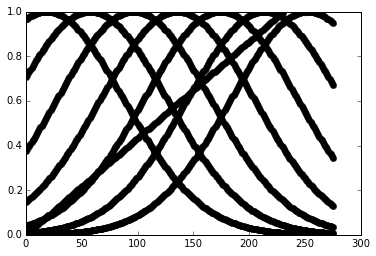

In [5]:
X_basis = basis_functions(X_tmp, 7, 231)
for basis in X_basis.T:
    plt.plot(basis, 'ok')
    
print X_basis.shape

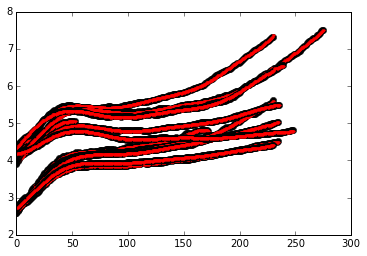

In [6]:
stress_model = LinearRegression()

stresses = [i[:, 1] for i in X_tmp]

l_min = [s.shape[-1] for s in stresses]
stress_basis = []
stress_intercept = []
for stress, l in zip(stresses, l_min):
    stress_model.fit(X_basis[:l], stress)
    _inter = np.repeat(stress_model.intercept_, X_basis[:l].shape[0])
    stress_basis.append(np.concatenate((X_basis[:l].T * stress_model.coef_.T[:, None],
                                        _inter[None])))

for sample, stress in zip(stress_basis, stresses):
    plt.plot(stress, 'ok')
    plt.plot(np.sum(sample, axis=0), '.r')

In [7]:
non_linear_stress = True

if non_linear_stress is True:
    X_ = [np.concatenate((i[:, :1], j[:].T, i[:, 2:]), axis=-1) for i, j in zip(X_tmp, stress_basis)]
    exogenious = range(11) # 0 - Strain, 1 through 10 - Stress, 11 - % Crystalline,
else:
    X_ = X_tmp
    exogenious = range(1) # 0 - Strain, 1 - Stress, 2 - % Crystalline,
print X_[0].shape


poly_order = 1

(173, 18)


In [8]:
exogenious

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

#Make Regression model

In [9]:
model = Pipeline([('poly', PolynomialFeatures(poly_order)), ('linear', LinearRegression())])

#Select training dataset and regressors

In [10]:
n_regressors = exogenious
n_exo = len(exogenious)
if ar_order > 0:
    n_regressors = n_regressors + range(3, 3 + 7 * ar_order) # 3-9 - PCs
train_samples = [0, 1, 2, 3, 6, 7, 8, 9]

print n_regressors

X = np.concatenate(([X_[sample] for sample in train_samples]))
y = np.concatenate(([y_[sample] for sample in train_samples]))

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 3, 4, 5, 6, 7, 8, 9]


$$y_t = \beta_1 y_{t-1} + \beta_2 strain + e$$

#Fit model

In [11]:
model.fit(X[:, n_regressors], y)

Pipeline(steps=[('poly', PolynomialFeatures(degree=1, include_bias=True, interaction_only=False)), ('linear', LinearRegression(copy_X=True, fit_intercept=True, normalize=False))])

#Check fit

In [12]:
print 'R-squared', model.score(X[:, n_regressors], y)
print 'MSE', mse(y, model.predict(X[:, n_regressors]))
print 'Sum Euclidean Distance Between Points', np.linalg.norm(model.predict(X[:, n_regressors]) - y)

R-squared 0.817419172161
MSE 21.1543497464
Sum Euclidean Distance Between Points 496.691077776


#Select Testing Dataset

In [13]:
test_samples = [4]
X_test = np.concatenate(([X_[sample] for sample in test_samples]))
y_test = np.concatenate(([y_[sample] for sample in test_samples]))

#Predict new locations

In [14]:
y_pred_test = model.predict(X_test[:, n_regressors])
print 'R-squared', model.score(X_test[:, n_regressors], y_test)
print 'Sum Euclidean Distance Between Points', np.linalg.norm(y_pred_test - y_test)
print 'MSE', mse(y_pred_test, y_test)

R-squared 0.711935963313
Sum Euclidean Distance Between Points 197.66954591
MSE 23.7527351856


In [15]:
def _project_predict(X__, y__, ar_order, model, n_regressors, x_terms):
    y__project = np.zeros(y__.shape)
    X__project = X__.copy()
    ar_list = range(ar_order + 1)[1:]
    n_pcs = y__.shape[-1]
    for ii in range(X__.shape[0] - ar_order):
        y__project[ii] =  model.predict(X__project[ii, n_regressors])
        for ar in ar_list:
            ar_index = list(np.array(n_regressors[x_terms:]) + n_pcs * (ar - 1))
            X__project[ii + 1, ar_index] = y__project[ii + 1 - ar]
    return X__project, y__project

In [16]:
print X_test.shape
X_project, y_project = _project_predict(X_test, y_test, ar_order, model,
                                        n_regressors, len(exogenious))

(235, 18)


In [17]:
print 'R-squared', model.score(X_project[:, n_regressors], y_test)
print 'Sum Euclidean Distance Between Points', np.linalg.norm(y_project - y_test)
print 'MSE', mse(y_project, y_test)

R-squared -719.776003198
Sum Euclidean Distance Between Points 9868.94948086
MSE 59207.3944411


#Plot Training Results

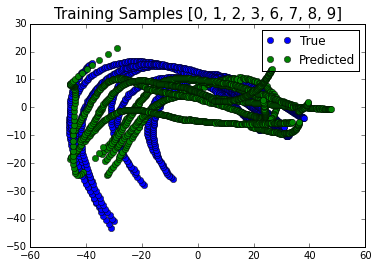

In [18]:
n_components = [0, 1]
y_pred = model.predict(X[:, n_regressors])
plt.plot(y[:, n_components[0]], y[:, n_components[1]], 'bo', label='True')
plt.plot(y_pred[:, n_components[0]], y_pred[:, n_components[1]], 'go', label='Predicted')
plt.legend(loc=n_components[1])
plt.title('Training Samples ' + str(train_samples), fontsize=15)

#Plot Testing Results

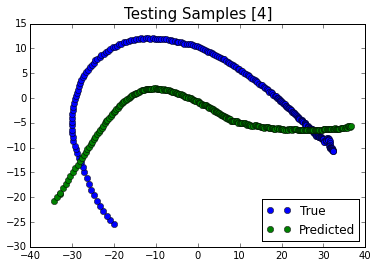

In [19]:
plt.plot(y_test[:, n_components[0]], y_test[:, n_components[1]], 'bo', label='True')
plt.plot(y_pred_test[:, n_components[0]], y_pred_test[:, n_components[1]], 'go', label='Predicted')
plt.legend(loc=4)
plt.title('Testing Samples ' + str(test_samples), fontsize=15)

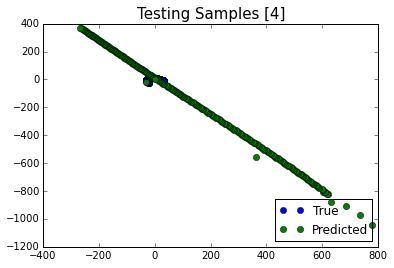

In [20]:
plt.plot(y_test[:, n_components[0]], y_test[:, n_components[1]], 'bo', label='True')
plt.plot(y_project[:, n_components[0]], y_project[:, n_components[1]], 'go', label='Predicted')
plt.legend(loc=4)
plt.title('Testing Samples ' + str(test_samples), fontsize=15)